In [69]:
import os
import glob
import torch
import copy

import pandas as pd
from tqdm.auto import tqdm

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # For better visualization

# Mi módulo
from utils import preproces_for_new_architecture

torch.manual_seed(42)

## Data Set "Cough Trial Extended" de Kaggle 

In [2]:
fn_dataset = 'data/kaggle/cough_trial_extended.csv'
df_dataset = pd.read_csv(fn_dataset)

print('Total number of examples:', len(df_dataset))
print('Number of positive examples:', len(df_dataset[df_dataset['class'] == 'covid']))
print('Number of negative examples:', len(df_dataset[df_dataset['class'] == 'not_covid']))

df_dataset.head()

Total number of examples: 170
Number of positive examples: 19
Number of negative examples: 151


,file_properties,class
0,0v8MGxNetjg_ 10.000_ 20.000.wav,not_covid
1,1j1duoxdxBg_ 70.000_ 80.000.wav,not_covid
2,1MSYO4wgiag_ 120.000_ 130.000.wav,not_covid
3,1PajbAKd8Kg_ 0.000_ 10.000.wav,not_covid
4,cov1.wav,covid


In [3]:
import numpy as np
import os
from tqdm import tqdm
import pandas as pd

# Define columns for scalar features
df_features_cols = ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate']
for i in range(1, 21):
    df_features_cols.append(f'mfcc{i}')
df_features_cols.append('label')

# Create DataFrames
df_features = pd.DataFrame(columns=df_features_cols)

# Create dictionaries to store 2D features
spectrograms = {}
chromagrams = {}

for row_index, row in tqdm(df_dataset.iterrows(), total=len(df_dataset)):
    fn_wav = os.path.join('data/kaggle/trial_covid/', row['file_properties'])
    feature_row = preproces_for_new_architecture(fn_wav)
    
    # Handle scalar features for CSV
    scalar_features = {
        'filename': row['file_properties'],
        'label': row['class'],
        'chroma_stft': feature_row['chroma_stft'],
        'rmse': feature_row['rmse'],
        'spectral_centroid': feature_row['spectral_centroid'],
        'spectral_bandwidth': feature_row['spectral_bandwidth'],
        'rolloff': feature_row['rolloff'],
        'zero_crossing_rate': feature_row['zero_crossing_rate']
    }
    
    # Add MFCC features
    for i in range(1, 21):
        scalar_features[f'mfcc{i}'] = feature_row[f'mfcc{i}']
    
    feature_row_df = pd.DataFrame([scalar_features])
    df_features = pd.concat([df_features, feature_row_df], ignore_index=True)
    
    # Store 2D features with filename as key
    filename = row['file_properties']
    spectrograms[filename] = feature_row['mel_spectrogram']
    chromagrams[filename] = feature_row['chromagram']

# Save scalar features to CSV
df_features.to_csv('data/prepared_data_kaggle_cnn.csv', index=False, columns=df_features_cols)

# Save 2D features to NPZ file (compressed numpy format)
np.savez_compressed('data/2d_features.npz',
                   spectrograms=spectrograms,
                   chromagrams=chromagrams,
                   filenames=list(spectrograms.keys()),
                   labels=df_features['label'].values)

# Function to load the 2D features later
def load_2d_features():
    data = np.load('data/2d_features.npz', allow_pickle=True)
    spectrograms = data['spectrograms'].item()
    chromagrams = data['chromagrams'].item()
    filenames = data['filenames']
    labels = data['labels']
    return spectrograms, chromagrams, filenames, labels

# Example of how to prepare data for training:
def prepare_2d_data_for_training():
    spectrograms, chromagrams, filenames, labels = load_2d_features()
    
    # Convert dictionaries to arrays
    X_spec = np.stack([spectrograms[f] for f in filenames])
    X_chroma = np.stack([chromagrams[f] for f in filenames])
    y = labels
    
    
    X_spec_train, X_spec_test, X_chroma_train, X_chroma_test, y_train, y_test = train_test_split(
        X_spec, X_chroma, y, test_size=0.2, random_state=42
    )
    
    return {
        'spectrogram': {
            'train': X_spec_train,
            'test': X_spec_test
        },
        'chromagram': {
            'train': X_chroma_train,
            'test': X_chroma_test
        },
        'labels': {
            'train': y_train,
            'test': y_test
        }
    }

  0%|          | 0/170 [00:00<?, ?it/s]/var/folders/js/4gyf2ycn0psfjp__7974j73h0000gn/T/ipykernel_88296/3866710988.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_features = pd.concat([df_features, feature_row_df], ignore_index=True)
100%|██████████| 170/170 [00:06<00:00, 24.76it/s]


### Agregando más datos: data set "Virufy"!

In [4]:
import glob
import pandas as pd
import numpy as np
from sklearn.utils import resample

# First create Virufy dataset DataFrame
df_dataset = pd.DataFrame(columns=['file_properties', 'class'])
for fn in glob.glob('data/virufy/clinical/segmented/pos/*.mp3'):
    new_row = pd.DataFrame([{'file_properties': fn, 'class': 'covid'}])
    df_dataset = pd.concat([df_dataset, new_row], ignore_index=True)
    
for fn in glob.glob('data/virufy/clinical/segmented/neg/*.mp3'):
    new_row = pd.DataFrame([{'file_properties': fn, 'class': 'not_covid'}])
    df_dataset = pd.concat([df_dataset, new_row], ignore_index=True)

print('Total number of examples:', len(df_dataset))
print('Number of positive examples:', len(df_dataset[df_dataset['class'] == 'covid']))
print('Number of negative examples:', len(df_dataset[df_dataset['class'] == 'not_covid']))

# Create dictionaries to store 2D features for Virufy
spectrograms = {}
chromagrams = {}

# Process Virufy data and create NPZ
for row_index, row in tqdm(df_dataset.iterrows(), total=len(df_dataset)):
    fn_wav = row['file_properties']
    feature_row = preproces_for_new_architecture(fn_wav)
    
    # Store 2D features with filename as key
    filename = row['file_properties']
    spectrograms[filename] = feature_row['mel_spectrogram']
    chromagrams[filename] = feature_row['chromagram']

# Save Virufy 2D features
np.savez_compressed('data/2d_features_virufy.npz',
                   spectrograms=spectrograms,
                   chromagrams=chromagrams,
                   filenames=list(spectrograms.keys()),
                   labels=df_dataset['class'].values)

# Now combine with existing Kaggle data
# Load both NPZ files
kaggle_2d = np.load('data/2d_features.npz', allow_pickle=True)
virufy_2d = np.load('data/2d_features_virufy.npz', allow_pickle=True)

# Combine 2D features
combined_spectrograms = {**kaggle_2d['spectrograms'].item(), **virufy_2d['spectrograms'].item()}
combined_chromagrams = {**kaggle_2d['chromagrams'].item(), **virufy_2d['chromagrams'].item()}

# Load and combine scalar features CSV
df_features_kaggle = pd.read_csv('data/prepared_data_kaggle.csv')
df_features_virufy = pd.read_csv('data/prepared_data_virufy.csv')
df_features = pd.concat([df_features_kaggle, df_features_virufy])

# Save combined scalar features
df_features.to_csv('data/prepared_data_cnn.csv', index=False, columns=df_features_cols)

# Save combined 2D features
np.savez_compressed('data/2d_features_combined.npz',
                   spectrograms=combined_spectrograms,
                   chromagrams=combined_chromagrams,
                   filenames=list(combined_spectrograms.keys()),
                   labels=df_features['label'].values)

# Balance the dataset as before
df_majority = df_features[df_features['label'] == 'not_covid']
df_minority = df_features[df_features['label'] == 'covid']

df_majority_balanced = resample(df_majority, 
                              replace=False, 
                              n_samples=len(df_minority),
                              random_state=42)

df_balanced = pd.concat([df_majority_balanced, df_minority])

# Get balanced filenames
balanced_filenames = df_balanced['filename'].values

# Create balanced 2D features
balanced_spectrograms = {k: combined_spectrograms[k] for k in balanced_filenames}
balanced_chromagrams = {k: combined_chromagrams[k] for k in balanced_filenames}

# Save balanced data
df_balanced.to_csv('data/prepared_data_balanced.csv', index=False)
np.savez_compressed('data/2d_features_balanced.npz',
                   spectrograms=balanced_spectrograms,
                   chromagrams=balanced_chromagrams,
                   filenames=balanced_filenames,
                   labels=df_balanced['label'].values)

print('Final balanced dataset:')
print('Total number of examples:', len(df_balanced))
print('Number of positive examples:', len(df_balanced[df_balanced['label'] == 'covid']))
print('Number of negative examples:', len(df_balanced[df_balanced['label'] == 'not_covid']))

Total number of examples: 121
Number of positive examples: 48
Number of negative examples: 73


100%|██████████| 121/121 [00:01<00:00, 68.12it/s]


Final balanced dataset:
Total number of examples: 134
Number of positive examples: 67
Number of negative examples: 67


In [5]:
df_balanced.columns

Index(['filename', 'chroma_stft', 'rmse', 'spectral_centroid',
       'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2',
       'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10',
       'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17',
       'mfcc18', 'mfcc19', 'mfcc20', 'label'],
      dtype='object')

In [91]:
df_balanced.shape

(134, 28)

## Modelo, dataloaders y parámetros de optimización

In [ ]:
hparams = {    
    'dataset': 'data/prepared_data_balanced.csv',
    'epochs': 50,
    'batch_size': 16,
    'lr': 1e-3,
    'features': [
        'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate',
        'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 
        'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20'
    ]
}

In [70]:
class CombinedDataset(Dataset):
    def __init__(self, scalar_features, spectrograms, chromagrams, labels):
        self.scalar_features = torch.FloatTensor(scalar_features)
        self.spectrograms = torch.FloatTensor(spectrograms)
        self.chromagrams = torch.FloatTensor(chromagrams)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (self.scalar_features[idx], 
                self.spectrograms[idx], 
                self.chromagrams[idx], 
                self.labels[idx])

In [71]:

class CoughNetWithCNN(torch.nn.Module):
    def __init__(self, scalar_input_size):
        super(CoughNetWithCNN, self).__init__()
        
        # CNN for spectrogram (input: batch x 1 x 128 x 128)
        self.spec_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 16 x 64 x 64
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 32 x 32 x 32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # -> 64 x 4 x 4
        )
        
        # CNN for chromagram (input: batch x 1 x 12 x 128)
        self.chroma_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 16 x 6 x 64
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((2, 4))  # -> 32 x 2 x 4
        )
        
        # Process scalar features
        self.scalar_net = nn.Sequential(
            nn.Linear(scalar_input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Final layers - combine all features
        spec_features = 64 * 4 * 4    # From spec_conv
        chroma_features = 32 * 2 * 4  # From chroma_conv
        combined_size = 64 + spec_features + chroma_features  # 64 from scalar_net
        
        self.classifier = nn.Sequential(
            nn.Linear(combined_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, scalar_x, spectrogram, chromagram):
        # Process scalar features
        scalar_features = self.scalar_net(scalar_x)
        
        # Process spectrogram - add channel dimension if needed
        
        if len(spectrogram.shape) == 3: 
            spectrogram = spectrogram.unsqueeze(1)
        spec_features = self.spec_conv(spectrogram)
        spec_features = spec_features.view(spec_features.size(0), -1) 
        
        # Process chromagram - add channel dimension if needed
        if len(chromagram.shape) == 3:
            chromagram = chromagram.unsqueeze(1)
        chroma_features = self.chroma_conv(chromagram)
        chroma_features = chroma_features.view(chroma_features.size(0), -1)
        
        # Combine all features
        combined = torch.cat([scalar_features, spec_features, chroma_features], dim=1)
        
        # Final classification
        return self.classifier(combined)

def prepare_data_loaders(scalar_features, spectrograms, chromagrams, labels, batch_size=32):
    # First create train/val indices
    dataset_size = len(labels)
    indices = list(range(dataset_size))
    train_size = int(0.8 * dataset_size)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    # Scale scalar features using only training data
    scaler = StandardScaler()
    scalar_features_train = scaler.fit_transform(scalar_features[train_indices])
    scalar_features_val = scaler.transform(scalar_features[val_indices])
    
    # Create separate datasets for train and validation
    train_dataset = CombinedDataset(
        scalar_features_train,
        spectrograms[train_indices],
        chromagrams[train_indices],
        labels[train_indices]
    )
    
    val_dataset = CombinedDataset(
        scalar_features_val,
        spectrograms[val_indices],
        chromagrams[val_indices],
        labels[val_indices]
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, scaler

### Seteando optimizadores, función objetivo y cargando datos preprocesados anteriormente

In [7]:
# inicializacion
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CoughNetWithCNN(scalar_input_size=len(hparams['features'])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])
criterion = torch.nn.CrossEntropyLoss()

# Preparando los datos
scalar_features = df_balanced.drop(['filename', 'label'], axis=1).values
labels = (df_balanced['label'] == 'covid').astype(int).values

# Cargando las features en 2 dimensiones
npz_data = np.load('data/2d_features_balanced.npz', allow_pickle=True)
spectrograms = np.stack([npz_data['spectrograms'].item()[fn] for fn in df_balanced['filename']])
chromagrams = np.stack([npz_data['chromagrams'].item()[fn] for fn in df_balanced['filename']])


In [8]:
print(f"spectrograms shape: {spectrograms.shape}")
print(f"chromagrams shape: {chromagrams.shape}")

spectrograms shape: (134, 128, 128)
chromagrams shape: (134, 12, 128)


## Entrenando

In [11]:
train_loader, val_loader, scaler = prepare_data_loaders(scalar_features, spectrograms, chromagrams, labels)

In [12]:
def train(loader_train, model, optimizer, epoch):
    
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    pbar = tqdm(enumerate(loader_train), total=len(loader_train))
    
    for batch_ndx, sample in pbar:
        # Unpack the sample with all three types of features
        scalar_features, spectrograms, chromagrams, labels = (
            sample[0].to(device), 
            sample[1].to(device),
            sample[2].to(device),
            sample[3].to(device)
        )

        # Forward pass and loss calculation
        outputs = model(scalar_features, spectrograms, chromagrams)
        loss = criterion(outputs, labels)
        
        # Backward pass    
        loss.backward()
        
        # Update weights
        optimizer.step()
        optimizer.zero_grad()
        
        # Calculate metrics
        running_loss += loss.item()
        predictions = torch.argmax(outputs.data, 1)
        running_correct += (predictions == labels).sum().item()

        # Print information
        pbar.set_description(f'[Training Epoch {epoch+1}]')
        total += labels.shape[0]
        pbar.set_postfix({
            'loss': running_loss / total, 
            'train_accuracy': running_correct / total
        })
        
    # Write information to tensorboard
    writer.add_scalar('Loss/Train', running_loss / total, epoch+1)
    writer.add_scalar('Accuracy/Train', running_correct / total, epoch+1)
    
    return running_loss / total, running_correct / total

def evaluate(loader_test, model, epoch):
    model.eval()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(enumerate(loader_test), total=len(loader_test))
        for batch_ndx, sample in pbar:
            # Unpack the sample
            scalar_features, spectrograms, chromagrams, labels = (
                sample[0].to(device), 
                sample[1].to(device),
                sample[2].to(device),
                sample[3].to(device)
            )

            # Forward pass and loss calculation
            outputs = model(scalar_features, spectrograms, chromagrams)
            loss = criterion(outputs, labels)

            # Calculate metrics
            running_loss += loss.item()
            predictions = torch.argmax(outputs.data, 1)
            running_correct += (predictions == labels).sum().item()

            # Print information
            pbar.set_description(f'[Evaluating Epoch {epoch+1}]')
            total += labels.shape[0]
            pbar.set_postfix({
                'loss': running_loss / total, 
                'eval_accuracy': running_correct / total
            })
        
    # Write information to tensorboard
    writer.add_scalar('Loss/Eval', running_loss / total, epoch+1)
    writer.add_scalar('Accuracy/Eval', running_correct / total, epoch+1)
    
    return running_loss / total, running_correct / total

# Initialize tensorboard summary writer
time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
writer = SummaryWriter(f'logs/{time_stamp}/')

# Add graph to tensorboard
sample = next(iter(train_loader))
scalar_features, spectrograms, chromagrams = sample[0][:1], sample[1][:1], sample[2][:1]
writer.add_graph(model, (scalar_features, spectrograms, chromagrams))

# Training loop
best_val_loss = float('inf')
best_model_state = None

print("Starting training...")
for epoch in range(hparams['epochs']):
    train_loss, train_acc = train(train_loader, model, optimizer, epoch)
    val_loss, val_acc = evaluate(val_loader, model, epoch)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        print(f'New best model saved with validation loss: {val_loss:.4f}')
    
    print(f'Epoch {epoch+1}/{hparams["epochs"]}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


# Guardando el modelo
torch.save({
    'hparams': hparams,
    'model_state': model.state_dict(),
    'scaler': scaler,
    'epoch': epoch,
    'model_state_dict': best_model_state,
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_loss': best_val_loss,
}, f'checkpoints/best_model_cnn_{time_stamp}.pth')

# Close tensorboard
writer.close()

print("Training completed!")
print("To view training progress, run:")
print("tensorboard --logdir logs")

Starting training...


[Evaluating Epoch 1]: 100%|██████████| 1/1 [00:00<00:00, 27.72it/s, loss=0.0573, eval_accuracy=0]


New best model saved with validation loss: 0.0573
Epoch 1/50:
Train Loss: 0.0241, Train Acc: 0.6262
Val Loss: 0.0573, Val Acc: 0.0000


[Evaluating Epoch 2]: 100%|██████████| 1/1 [00:00<00:00, 27.19it/s, loss=0.0235, eval_accuracy=1]


New best model saved with validation loss: 0.0235
Epoch 2/50:
Train Loss: 0.0261, Train Acc: 0.6355
Val Loss: 0.0235, Val Acc: 1.0000


[Evaluating Epoch 3]: 100%|██████████| 1/1 [00:00<00:00, 27.46it/s, loss=0.026, eval_accuracy=0]


Epoch 3/50:
Train Loss: 0.0259, Train Acc: 0.5327
Val Loss: 0.0260, Val Acc: 0.0000


[Evaluating Epoch 4]: 100%|██████████| 1/1 [00:00<00:00, 27.90it/s, loss=0.0318, eval_accuracy=0]


Epoch 4/50:
Train Loss: 0.0246, Train Acc: 0.6075
Val Loss: 0.0318, Val Acc: 0.0000


[Evaluating Epoch 5]: 100%|██████████| 1/1 [00:00<00:00, 28.55it/s, loss=0.0276, eval_accuracy=0]


Epoch 5/50:
Train Loss: 0.0238, Train Acc: 0.6636
Val Loss: 0.0276, Val Acc: 0.0000


[Evaluating Epoch 6]: 100%|██████████| 1/1 [00:00<00:00, 27.76it/s, loss=0.0201, eval_accuracy=1]


New best model saved with validation loss: 0.0201
Epoch 6/50:
Train Loss: 0.0229, Train Acc: 0.6542
Val Loss: 0.0201, Val Acc: 1.0000


[Evaluating Epoch 7]: 100%|██████████| 1/1 [00:00<00:00, 26.36it/s, loss=0.0199, eval_accuracy=1]


New best model saved with validation loss: 0.0199
Epoch 7/50:
Train Loss: 0.0241, Train Acc: 0.6542
Val Loss: 0.0199, Val Acc: 1.0000


[Evaluating Epoch 8]: 100%|██████████| 1/1 [00:00<00:00, 27.48it/s, loss=0.0248, eval_accuracy=0.889]


Epoch 8/50:
Train Loss: 0.0218, Train Acc: 0.6636
Val Loss: 0.0248, Val Acc: 0.8889


[Evaluating Epoch 9]: 100%|██████████| 1/1 [00:00<00:00, 26.51it/s, loss=0.026, eval_accuracy=0.37]


Epoch 9/50:
Train Loss: 0.0218, Train Acc: 0.6822
Val Loss: 0.0260, Val Acc: 0.3704


[Evaluating Epoch 10]: 100%|██████████| 1/1 [00:00<00:00, 28.35it/s, loss=0.0249, eval_accuracy=0.704]


Epoch 10/50:
Train Loss: 0.0218, Train Acc: 0.6449
Val Loss: 0.0249, Val Acc: 0.7037


[Evaluating Epoch 11]: 100%|██████████| 1/1 [00:00<00:00, 27.28it/s, loss=0.0235, eval_accuracy=0.926]


Epoch 11/50:
Train Loss: 0.0218, Train Acc: 0.6542
Val Loss: 0.0235, Val Acc: 0.9259


[Evaluating Epoch 12]: 100%|██████████| 1/1 [00:00<00:00, 27.23it/s, loss=0.025, eval_accuracy=0.667]


Epoch 12/50:
Train Loss: 0.0194, Train Acc: 0.7103
Val Loss: 0.0250, Val Acc: 0.6667


[Evaluating Epoch 13]: 100%|██████████| 1/1 [00:00<00:00, 27.77it/s, loss=0.02, eval_accuracy=1]


Epoch 13/50:
Train Loss: 0.0207, Train Acc: 0.6729
Val Loss: 0.0200, Val Acc: 1.0000


[Evaluating Epoch 14]: 100%|██████████| 1/1 [00:00<00:00, 28.60it/s, loss=0.0213, eval_accuracy=0.889]


Epoch 14/50:
Train Loss: 0.0188, Train Acc: 0.7850
Val Loss: 0.0213, Val Acc: 0.8889


[Evaluating Epoch 15]: 100%|██████████| 1/1 [00:00<00:00, 29.04it/s, loss=0.0249, eval_accuracy=0.556]


Epoch 15/50:
Train Loss: 0.0186, Train Acc: 0.7944
Val Loss: 0.0249, Val Acc: 0.5556


[Evaluating Epoch 16]: 100%|██████████| 1/1 [00:00<00:00, 27.73it/s, loss=0.0234, eval_accuracy=0.63]


Epoch 16/50:
Train Loss: 0.0172, Train Acc: 0.8224
Val Loss: 0.0234, Val Acc: 0.6296


[Evaluating Epoch 17]: 100%|██████████| 1/1 [00:00<00:00, 28.12it/s, loss=0.0166, eval_accuracy=0.889]


New best model saved with validation loss: 0.0166
Epoch 17/50:
Train Loss: 0.0162, Train Acc: 0.7850
Val Loss: 0.0166, Val Acc: 0.8889


[Evaluating Epoch 18]: 100%|██████████| 1/1 [00:00<00:00, 28.93it/s, loss=0.0215, eval_accuracy=0.704]


Epoch 18/50:
Train Loss: 0.0160, Train Acc: 0.7850
Val Loss: 0.0215, Val Acc: 0.7037


[Evaluating Epoch 19]: 100%|██████████| 1/1 [00:00<00:00, 28.12it/s, loss=0.0158, eval_accuracy=0.852]


New best model saved with validation loss: 0.0158
Epoch 19/50:
Train Loss: 0.0127, Train Acc: 0.8692
Val Loss: 0.0158, Val Acc: 0.8519


[Evaluating Epoch 20]: 100%|██████████| 1/1 [00:00<00:00, 27.12it/s, loss=0.0321, eval_accuracy=0.407]


Epoch 20/50:
Train Loss: 0.0125, Train Acc: 0.8692
Val Loss: 0.0321, Val Acc: 0.4074


[Evaluating Epoch 21]: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s, loss=0.015, eval_accuracy=0.852]


New best model saved with validation loss: 0.0150
Epoch 21/50:
Train Loss: 0.0128, Train Acc: 0.8318
Val Loss: 0.0150, Val Acc: 0.8519


[Evaluating Epoch 22]: 100%|██████████| 1/1 [00:00<00:00, 27.03it/s, loss=0.0278, eval_accuracy=0.556]


Epoch 22/50:
Train Loss: 0.0112, Train Acc: 0.8785
Val Loss: 0.0278, Val Acc: 0.5556


[Evaluating Epoch 23]: 100%|██████████| 1/1 [00:00<00:00, 27.67it/s, loss=0.0188, eval_accuracy=0.704]


Epoch 23/50:
Train Loss: 0.0098, Train Acc: 0.9065
Val Loss: 0.0188, Val Acc: 0.7037


[Evaluating Epoch 24]: 100%|██████████| 1/1 [00:00<00:00, 27.23it/s, loss=0.0257, eval_accuracy=0.556]


Epoch 24/50:
Train Loss: 0.0106, Train Acc: 0.8785
Val Loss: 0.0257, Val Acc: 0.5556


[Evaluating Epoch 25]: 100%|██████████| 1/1 [00:00<00:00, 26.83it/s, loss=0.0353, eval_accuracy=0.444]


Epoch 25/50:
Train Loss: 0.0114, Train Acc: 0.8785
Val Loss: 0.0353, Val Acc: 0.4444


[Evaluating Epoch 26]: 100%|██████████| 1/1 [00:00<00:00, 28.16it/s, loss=0.0198, eval_accuracy=0.704]


Epoch 26/50:
Train Loss: 0.0080, Train Acc: 0.9252
Val Loss: 0.0198, Val Acc: 0.7037


[Evaluating Epoch 27]: 100%|██████████| 1/1 [00:00<00:00, 27.17it/s, loss=0.024, eval_accuracy=0.593]


Epoch 27/50:
Train Loss: 0.0079, Train Acc: 0.8972
Val Loss: 0.0240, Val Acc: 0.5926


[Evaluating Epoch 28]: 100%|██████████| 1/1 [00:00<00:00, 26.98it/s, loss=0.0207, eval_accuracy=0.704]


Epoch 28/50:
Train Loss: 0.0081, Train Acc: 0.9065
Val Loss: 0.0207, Val Acc: 0.7037


[Evaluating Epoch 29]: 100%|██████████| 1/1 [00:00<00:00, 24.16it/s, loss=0.0284, eval_accuracy=0.556]


Epoch 29/50:
Train Loss: 0.0078, Train Acc: 0.9252
Val Loss: 0.0284, Val Acc: 0.5556


[Evaluating Epoch 30]: 100%|██████████| 1/1 [00:00<00:00, 27.66it/s, loss=0.0194, eval_accuracy=0.704]


Epoch 30/50:
Train Loss: 0.0070, Train Acc: 0.9439
Val Loss: 0.0194, Val Acc: 0.7037


[Evaluating Epoch 31]: 100%|██████████| 1/1 [00:00<00:00, 26.98it/s, loss=0.0143, eval_accuracy=0.741]


New best model saved with validation loss: 0.0143
Epoch 31/50:
Train Loss: 0.0059, Train Acc: 0.9252
Val Loss: 0.0143, Val Acc: 0.7407


[Evaluating Epoch 32]: 100%|██████████| 1/1 [00:00<00:00, 26.92it/s, loss=0.0428, eval_accuracy=0.37]


Epoch 32/50:
Train Loss: 0.0061, Train Acc: 0.8972
Val Loss: 0.0428, Val Acc: 0.3704


[Evaluating Epoch 33]: 100%|██████████| 1/1 [00:00<00:00, 27.66it/s, loss=0.0176, eval_accuracy=0.741]


Epoch 33/50:
Train Loss: 0.0058, Train Acc: 0.9439
Val Loss: 0.0176, Val Acc: 0.7407


[Evaluating Epoch 34]: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s, loss=0.0198, eval_accuracy=0.704]


Epoch 34/50:
Train Loss: 0.0073, Train Acc: 0.8879
Val Loss: 0.0198, Val Acc: 0.7037


[Evaluating Epoch 35]: 100%|██████████| 1/1 [00:00<00:00, 27.80it/s, loss=0.0258, eval_accuracy=0.63]


Epoch 35/50:
Train Loss: 0.0061, Train Acc: 0.9533
Val Loss: 0.0258, Val Acc: 0.6296


[Evaluating Epoch 36]: 100%|██████████| 1/1 [00:00<00:00, 28.50it/s, loss=0.019, eval_accuracy=0.704]


Epoch 36/50:
Train Loss: 0.0041, Train Acc: 0.9439
Val Loss: 0.0190, Val Acc: 0.7037


[Evaluating Epoch 37]: 100%|██████████| 1/1 [00:00<00:00, 28.18it/s, loss=0.0299, eval_accuracy=0.519]


Epoch 37/50:
Train Loss: 0.0047, Train Acc: 0.9346
Val Loss: 0.0299, Val Acc: 0.5185


[Evaluating Epoch 38]: 100%|██████████| 1/1 [00:00<00:00, 27.47it/s, loss=0.0236, eval_accuracy=0.667]


Epoch 38/50:
Train Loss: 0.0052, Train Acc: 0.9533
Val Loss: 0.0236, Val Acc: 0.6667


[Evaluating Epoch 39]: 100%|██████████| 1/1 [00:00<00:00, 26.04it/s, loss=0.0251, eval_accuracy=0.63]


Epoch 39/50:
Train Loss: 0.0061, Train Acc: 0.9346
Val Loss: 0.0251, Val Acc: 0.6296


[Evaluating Epoch 40]: 100%|██████████| 1/1 [00:00<00:00, 28.15it/s, loss=0.0387, eval_accuracy=0.37]


Epoch 40/50:
Train Loss: 0.0055, Train Acc: 0.9439
Val Loss: 0.0387, Val Acc: 0.3704


[Evaluating Epoch 41]: 100%|██████████| 1/1 [00:00<00:00, 27.04it/s, loss=0.0291, eval_accuracy=0.556]


Epoch 41/50:
Train Loss: 0.0041, Train Acc: 0.9533
Val Loss: 0.0291, Val Acc: 0.5556


[Evaluating Epoch 42]: 100%|██████████| 1/1 [00:00<00:00, 27.76it/s, loss=0.0257, eval_accuracy=0.63]


Epoch 42/50:
Train Loss: 0.0052, Train Acc: 0.9439
Val Loss: 0.0257, Val Acc: 0.6296


[Evaluating Epoch 43]: 100%|██████████| 1/1 [00:00<00:00, 22.57it/s, loss=0.0327, eval_accuracy=0.481]


Epoch 43/50:
Train Loss: 0.0060, Train Acc: 0.9439
Val Loss: 0.0327, Val Acc: 0.4815


[Evaluating Epoch 44]: 100%|██████████| 1/1 [00:00<00:00, 28.39it/s, loss=0.0409, eval_accuracy=0.407]


Epoch 44/50:
Train Loss: 0.0042, Train Acc: 0.9533
Val Loss: 0.0409, Val Acc: 0.4074


[Evaluating Epoch 45]: 100%|██████████| 1/1 [00:00<00:00, 27.01it/s, loss=0.0231, eval_accuracy=0.667]


Epoch 45/50:
Train Loss: 0.0051, Train Acc: 0.9720
Val Loss: 0.0231, Val Acc: 0.6667


[Evaluating Epoch 46]: 100%|██████████| 1/1 [00:00<00:00, 29.30it/s, loss=0.0227, eval_accuracy=0.667]


Epoch 46/50:
Train Loss: 0.0047, Train Acc: 0.9626
Val Loss: 0.0227, Val Acc: 0.6667


[Evaluating Epoch 47]: 100%|██████████| 1/1 [00:00<00:00, 27.22it/s, loss=0.0256, eval_accuracy=0.667]


Epoch 47/50:
Train Loss: 0.0036, Train Acc: 0.9533
Val Loss: 0.0256, Val Acc: 0.6667


[Evaluating Epoch 48]: 100%|██████████| 1/1 [00:00<00:00, 27.58it/s, loss=0.0327, eval_accuracy=0.481]


Epoch 48/50:
Train Loss: 0.0044, Train Acc: 0.9533
Val Loss: 0.0327, Val Acc: 0.4815


[Evaluating Epoch 49]: 100%|██████████| 1/1 [00:00<00:00, 26.98it/s, loss=0.0397, eval_accuracy=0.407]


Epoch 49/50:
Train Loss: 0.0036, Train Acc: 0.9626
Val Loss: 0.0397, Val Acc: 0.4074


[Evaluating Epoch 50]: 100%|██████████| 1/1 [00:00<00:00, 26.36it/s, loss=0.0276, eval_accuracy=0.593]

Epoch 50/50:
Train Loss: 0.0035, Train Acc: 0.9626
Val Loss: 0.0276, Val Acc: 0.5926
Training completed!
To view training progress, run:
tensorboard --logdir logs


In [16]:
model_name_str = f"checkpoints/best_model_cnn_{time_stamp}.pth"
print(model_name_str)

checkpoints/best_model_cnn_20250128-200727.pth


Los números obtenidos parecen prometedores! pero debemos revisar

### Inferencia : testeando con un audio guardado que es covid positivo!

- Recordando que $[1, 0 ]$ es sano y $[0 , 1]$ es covid. 

- Cargamos el modelo 

- Procesamos el audio de prueba covid positivo

In [20]:
# load model from checkpoint
loaded_checkpoint = torch.load(model_name_str)
hparams = loaded_checkpoint['hparams']
scaler = loaded_checkpoint['scaler']
model = CoughNetWithCNN(len(hparams['features']))
model.eval()
model.load_state_dict(loaded_checkpoint['model_state'])

# Preprocess the wav file to get all features
feature_row = preproces_for_new_architecture(fn_wav)


/var/folders/js/4gyf2ycn0psfjp__7974j73h0000gn/T/ipykernel_88296/3748130281.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_checkpoint = torch.load(model_name_str

In [47]:
## Descomentar para observar
#feature_row

In [22]:
feature_row.keys()

dict_keys(['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mel_spectrogram', 'chromagram', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20'])

### Necesitamos cargar el audio, preprocesarlo y pasarselo al modelo

In [45]:
# Get features
fn_wav = 'data/test.wav' 
features = preproces_for_new_architecture(fn_wav)

# load model from checkpoint
loaded_checkpoint = torch.load(model_name_str)
hparams = loaded_checkpoint['hparams']
scaler = loaded_checkpoint['scaler']
model = CoughNetWithCNN(len(hparams['features']))
model.eval()
model.load_state_dict(loaded_checkpoint['model_state'])



# Prepare scalar features
scalar_features = []
for feature_name in hparams['features']:
    if feature_name not in ['mel_spectrogram', 'chromagram']:  # Exclude 2D features
        scalar_features.append(features[feature_name])

# Convert to DataFrame and scale
df_features = pd.DataFrame([scalar_features], columns=[f for f in hparams['features'] if f not in ['mel_spectrogram', 'chromagram']])
scalar_x = torch.Tensor(scaler.transform(df_features))

# Prepare spectrogram and chromagram
spec_x = torch.FloatTensor(features['mel_spectrogram']).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
chroma_x = torch.FloatTensor(features['chromagram']).unsqueeze(0).unsqueeze(0)     # Add batch and channel dimensions

# Get model prediction
with torch.no_grad():
    outputs = torch.softmax(model(scalar_x, spec_x, chroma_x), 1)
predictions = torch.argmax(outputs.data, 1)

# print result
print(f'model outputs {outputs[0].detach().numpy()} which predicts the class covid!')

# Optional: Print shapes to verify
print(f"Scalar features shape: {scalar_x.shape}")
print(f"Spectrogram shape: {spec_x.shape}")      # Should be [1, 1, 128, 128]
print(f"Chromagram shape: {chroma_x.shape}")     # Should be [1, 1, 12, 128]

model outputs [0.00264193 0.997358  ] which predicts the class covid!
Scalar features shape: torch.Size([1, 26])
Spectrogram shape: torch.Size([1, 1, 128, 128])
Chromagram shape: torch.Size([1, 1, 12, 128])


/var/folders/js/4gyf2ycn0psfjp__7974j73h0000gn/T/ipykernel_88296/1490952442.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_checkpoint = torch.load(model_name_str

## K-fold cross validation

- Estudiar!: por qué y para qué sirve K-fol cross validation

In [27]:
from sklearn.model_selection import KFold

In [34]:
# 1. Preparo los datos nuevamente
scalar_features = df_balanced.drop(['filename', 'label'], axis=1).values
labels = (df_balanced['label'] == 'covid').astype(int).values

# Cargamos las imagenes
npz_data = np.load('data/2d_features_balanced.npz', allow_pickle=True)
spectrograms = np.stack([npz_data['spectrograms'].item()[fn] for fn in df_balanced['filename']])
chromagrams = np.stack([npz_data['chromagrams'].item()[fn] for fn in df_balanced['filename']])

# 2. Aplicamos 8 folds
k_folds = 8
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
indices = np.arange(len(labels))
results_train = []
results_test = []

def train(loader_train, model, optimizer, epoch):
    model.train()
    running_correct = 0.0
    total = 0
    for batch_ndx, sample in enumerate(loader_train):
        scalar_features, spectrograms, chromagrams, labels = (
            sample[0].to(device),
            sample[1].to(device),
            sample[2].to(device),
            sample[3].to(device)
        )

        # forward pass and loss calculation
        outputs = model(scalar_features, spectrograms, chromagrams)
        loss = criterion(outputs, labels)

        # backward pass    
        loss.backward()
        
        # update weights
        optimizer.step()
        optimizer.zero_grad()

        # calculate metrics
        predictions = torch.argmax(outputs.data, 1)
        running_correct += (predictions == labels).sum().item()
        total += labels.shape[0]

    return running_correct / total

def evaluate(loader_test, model, epoch):
    model.eval()
    running_correct = 0.0
    total = 0
    with torch.no_grad():
        for batch_ndx, sample in enumerate(loader_test):
            scalar_features, spectrograms, chromagrams, labels = (
                sample[0].to(device),
                sample[1].to(device),
                sample[2].to(device),
                sample[3].to(device)
            )

            # forward pass and loss calculation
            outputs = model(scalar_features, spectrograms, chromagrams)
            loss = criterion(outputs, labels)

            # calculate metrics
            predictions = torch.argmax(outputs.data, 1)
            running_correct += (predictions == labels).sum().item()
            total += labels.shape[0]

    return running_correct / total

print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------------------')
print('|         | Train Accuracy | Test Accuracy |')
print('--------------------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold.split(indices)):
    # Split all features according to fold indices
    scalar_features_train = scalar_features[train_ids]
    spectrograms_train = spectrograms[train_ids]
    chromagrams_train = chromagrams[train_ids]
    y_train = labels[train_ids]
    
    scalar_features_test = scalar_features[test_ids]
    spectrograms_test = spectrograms[test_ids]
    chromagrams_test = chromagrams[test_ids]
    y_test = labels[test_ids]
    
    # Scale scalar features
    scaler = StandardScaler()
    scalar_features_train = scaler.fit_transform(scalar_features_train)
    scalar_features_test = scaler.transform(scalar_features_test)
    
    # Create datasets
    train_dataset = CombinedDataset(
        scalar_features_train,
        spectrograms_train,
        chromagrams_train,
        y_train
    )
    
    test_dataset = CombinedDataset(
        scalar_features_test,
        spectrograms_test,
        chromagrams_test,
        y_test
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=hparams['batch_size'],
        shuffle=True
    )
    
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=hparams['batch_size'],
        shuffle=False
    )
    
    # Create model
    model = CoughNetWithCNN(len(scalar_features_train[0])).to(device)

    # Construct loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])
    criterion = torch.nn.CrossEntropyLoss()

    # Add monitoring for best model
    best_accuracy = 0.0
    best_model_state = None

    # Training loop
    for epoch in range(hparams['epochs']):
        train_accuracy = train(train_loader, model, optimizer, epoch)
        eval_accuracy = evaluate(test_loader, model, epoch)
        
        # Print progress every 5 epochs
        if epoch % 5 == 0:
            print(f'Fold {fold}, Epoch {epoch}:')
            print(f'Training Accuracy: {train_accuracy*100:.2f}%')
            print(f'Validation Accuracy: {eval_accuracy*100:.2f}%')
            
        # Save best model
        if eval_accuracy > best_accuracy:
            best_accuracy = eval_accuracy
            best_model_state = copy.deepcopy(model.state_dict())
    
    # Save the best model for this fold
    torch.save({
        'fold': fold,
        'model_state': best_model_state,
        'scaler': scaler,
        'accuracy': best_accuracy,
        'hparams': hparams
    }, f'model_fold_{fold}.pth')
        
    results_train.append(train_accuracy)
    results_test.append(eval_accuracy)
    print(f'| Fold {fold}  |       {train_accuracy*100:.2f} % |       {eval_accuracy*100:.2f} % |')

print('--------------------------------------------')
print(f'| Average |       {np.mean(results_train)*100:.2f} % |       {np.mean(results_test)*100:.2f} % |')

K-FOLD CROSS VALIDATION RESULTS FOR 8 FOLDS
--------------------------------------------
|         | Train Accuracy | Test Accuracy |
--------------------------------------------
Fold 0, Epoch 0:
Training Accuracy: 62.39%
Validation Accuracy: 70.59%
Fold 0, Epoch 5:
Training Accuracy: 72.65%
Validation Accuracy: 70.59%
Fold 0, Epoch 10:
Training Accuracy: 77.78%
Validation Accuracy: 76.47%
Fold 0, Epoch 15:
Training Accuracy: 86.32%
Validation Accuracy: 88.24%
Fold 0, Epoch 20:
Training Accuracy: 89.74%
Validation Accuracy: 88.24%
Fold 0, Epoch 25:
Training Accuracy: 91.45%
Validation Accuracy: 94.12%
Fold 0, Epoch 30:
Training Accuracy: 93.16%
Validation Accuracy: 88.24%
Fold 0, Epoch 35:
Training Accuracy: 94.02%
Validation Accuracy: 88.24%
Fold 0, Epoch 40:
Training Accuracy: 94.02%
Validation Accuracy: 88.24%
Fold 0, Epoch 45:
Training Accuracy: 93.16%
Validation Accuracy: 94.12%
| Fold 0  |       94.02 % |       88.24 % |
Fold 1, Epoch 0:
Training Accuracy: 59.83%
Validation Accur

## Confusion Matrix

- Aqui es posible ver que para algunos folds el modelo hace overfitting y en otros se comporta de mejor forma. Esto porque tenemos pocos datos y el modelo parece ser el adecuado para capturar las características del audio. 

- En este caso el modelo requirió de "features" escogidas arbitrariamente (en genearl features frecuenciales) a las redes lineales; e imágenes como spectrograma y chromagram a las redes convolucionales. Ambas salidas se unen para dar mayor información al clasificador final. 

- Más abajo podrás ver que el modelo parece estable ante este grupo de audios seleccionados. Tal vez tocaría extender este análisis a todos los datasets disponibles (BA DATA, COUGH-VID) que parecen tener menor calidad o casos menos "evidentes" de enfermedad entre ambas clases. 

- Siempre habrán porciones o folds donde el modelo no es tan bueno. Es parte de la técnica evidenciar esta posibilidad.

In [37]:
#!pip install seaborn

In [41]:
def evaluate(loader_test, model, epoch, return_predictions=False):
    model.eval()
    running_correct = 0.0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_ndx, sample in enumerate(loader_test):
            scalar_features, spectrograms, chromagrams, labels = (
                sample[0].to(device),
                sample[1].to(device),
                sample[2].to(device),
                sample[3].to(device)
            )

            outputs = model(scalar_features, spectrograms, chromagrams)
            predictions = torch.argmax(outputs.data, 1)
            
            # Collect predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            running_correct += (predictions == labels).sum().item()
            total += labels.shape[0]

    if return_predictions:
        return running_correct / total, all_predictions, all_labels
    return running_correct / total

def plot_confusion_matrix(true_labels, predictions, fold=None):
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create figure
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='Blues', 
                xticklabels=['Non-COVID', 'COVID'],
                yticklabels=['Non-COVID', 'COVID'])
    
    # Add raw counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j+0.5, i+0.5, f'\n\n({cm[i, j]})', 
                    ha='center', va='center')
            

K-FOLD CROSS VALIDATION RESULTS FOR 8 FOLDS
--------------------------------------------
|         | Train Accuracy | Test Accuracy |
--------------------------------------------
Fold 0, Epoch 0:
Training Accuracy: 69.23%
Validation Accuracy: 58.82%
Fold 0, Epoch 5:
Training Accuracy: 71.79%
Validation Accuracy: 70.59%
Fold 0, Epoch 10:
Training Accuracy: 79.49%
Validation Accuracy: 76.47%
Fold 0, Epoch 15:
Training Accuracy: 81.20%
Validation Accuracy: 64.71%
Fold 0, Epoch 20:
Training Accuracy: 88.89%
Validation Accuracy: 88.24%
Fold 0, Epoch 25:
Training Accuracy: 91.45%
Validation Accuracy: 94.12%
Fold 0, Epoch 30:
Training Accuracy: 92.31%
Validation Accuracy: 94.12%
Fold 0, Epoch 35:
Training Accuracy: 93.16%
Validation Accuracy: 94.12%
Fold 0, Epoch 40:
Training Accuracy: 93.16%
Validation Accuracy: 94.12%
Fold 0, Epoch 45:
Training Accuracy: 93.16%
Validation Accuracy: 94.12%
| Fold 0  |       95.73 % |       94.12 % |


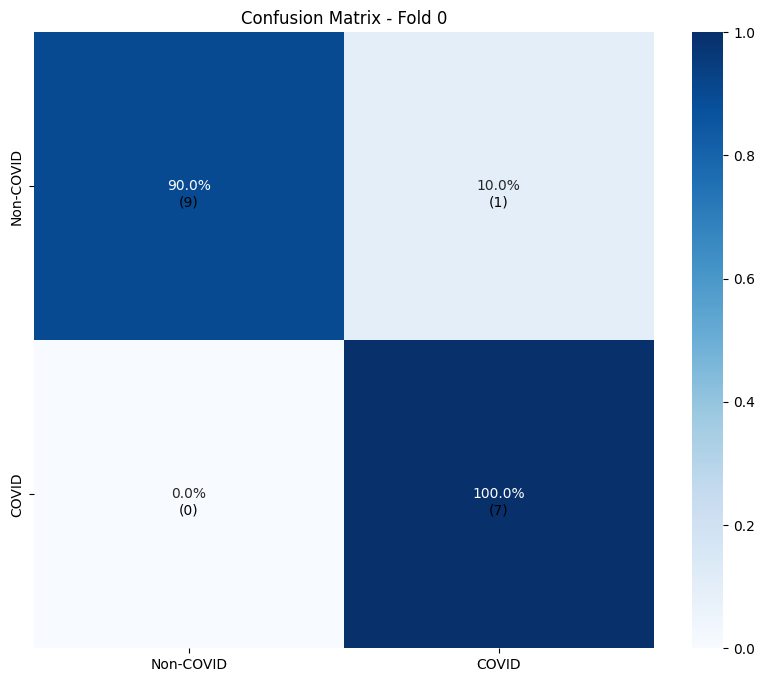

Fold 1, Epoch 0:
Training Accuracy: 60.68%
Validation Accuracy: 58.82%
Fold 1, Epoch 5:
Training Accuracy: 72.65%
Validation Accuracy: 58.82%
Fold 1, Epoch 10:
Training Accuracy: 82.05%
Validation Accuracy: 58.82%
Fold 1, Epoch 15:
Training Accuracy: 86.32%
Validation Accuracy: 64.71%
Fold 1, Epoch 20:
Training Accuracy: 91.45%
Validation Accuracy: 76.47%
Fold 1, Epoch 25:
Training Accuracy: 94.02%
Validation Accuracy: 76.47%
Fold 1, Epoch 30:
Training Accuracy: 94.02%
Validation Accuracy: 76.47%
Fold 1, Epoch 35:
Training Accuracy: 96.58%
Validation Accuracy: 76.47%
Fold 1, Epoch 40:
Training Accuracy: 96.58%
Validation Accuracy: 70.59%
Fold 1, Epoch 45:
Training Accuracy: 97.44%
Validation Accuracy: 76.47%
| Fold 1  |       95.73 % |       76.47 % |


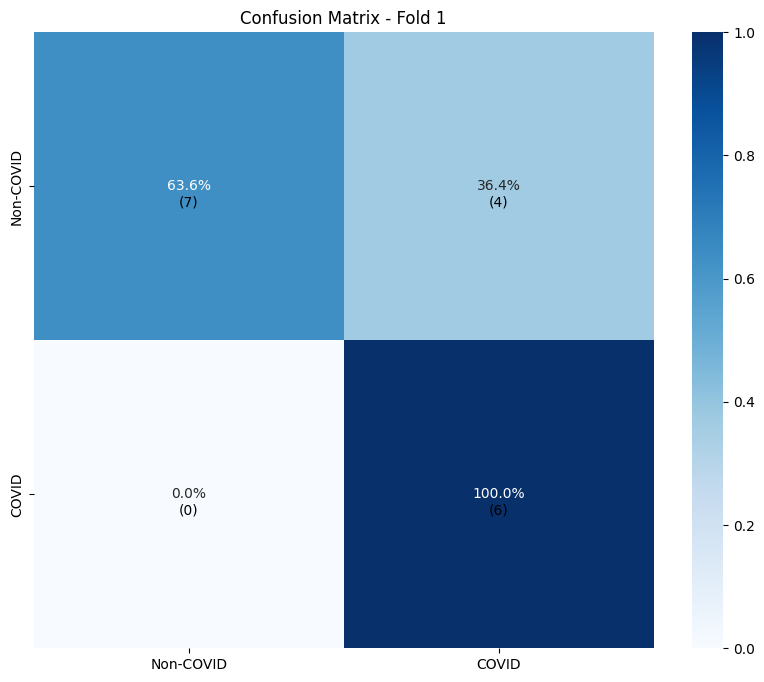

Fold 2, Epoch 0:
Training Accuracy: 55.56%
Validation Accuracy: 64.71%
Fold 2, Epoch 5:
Training Accuracy: 73.50%
Validation Accuracy: 64.71%
Fold 2, Epoch 10:
Training Accuracy: 75.21%
Validation Accuracy: 70.59%
Fold 2, Epoch 15:
Training Accuracy: 83.76%
Validation Accuracy: 76.47%
Fold 2, Epoch 20:
Training Accuracy: 86.32%
Validation Accuracy: 94.12%
Fold 2, Epoch 25:
Training Accuracy: 92.31%
Validation Accuracy: 94.12%
Fold 2, Epoch 30:
Training Accuracy: 91.45%
Validation Accuracy: 94.12%
Fold 2, Epoch 35:
Training Accuracy: 94.02%
Validation Accuracy: 94.12%
Fold 2, Epoch 40:
Training Accuracy: 94.02%
Validation Accuracy: 94.12%
Fold 2, Epoch 45:
Training Accuracy: 94.87%
Validation Accuracy: 94.12%
| Fold 2  |       95.73 % |       100.00 % |


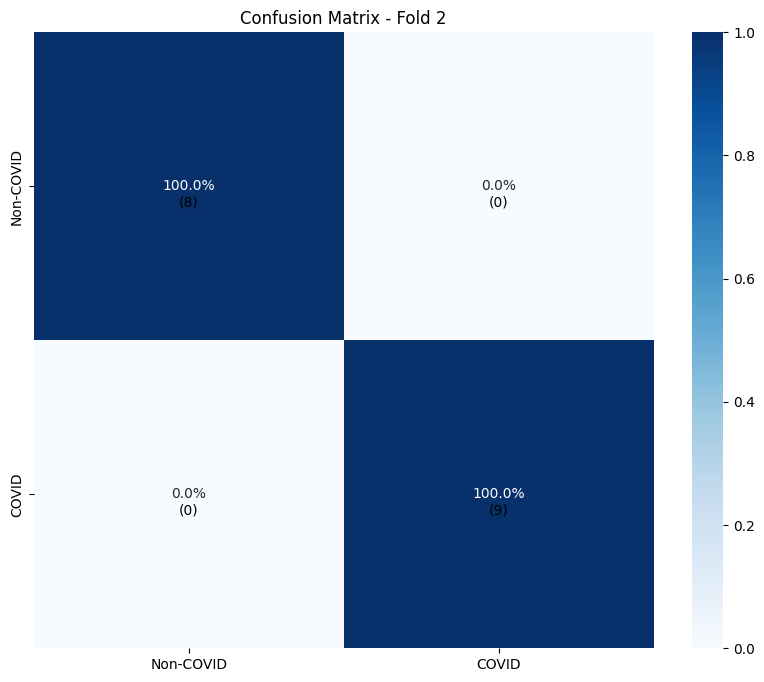

Fold 3, Epoch 0:
Training Accuracy: 58.97%
Validation Accuracy: 58.82%
Fold 3, Epoch 5:
Training Accuracy: 73.50%
Validation Accuracy: 52.94%
Fold 3, Epoch 10:
Training Accuracy: 80.34%
Validation Accuracy: 64.71%
Fold 3, Epoch 15:
Training Accuracy: 87.18%
Validation Accuracy: 76.47%
Fold 3, Epoch 20:
Training Accuracy: 92.31%
Validation Accuracy: 82.35%
Fold 3, Epoch 25:
Training Accuracy: 94.02%
Validation Accuracy: 88.24%
Fold 3, Epoch 30:
Training Accuracy: 93.16%
Validation Accuracy: 82.35%
Fold 3, Epoch 35:
Training Accuracy: 96.58%
Validation Accuracy: 82.35%
Fold 3, Epoch 40:
Training Accuracy: 94.02%
Validation Accuracy: 88.24%
Fold 3, Epoch 45:
Training Accuracy: 94.02%
Validation Accuracy: 82.35%
| Fold 3  |       96.58 % |       82.35 % |


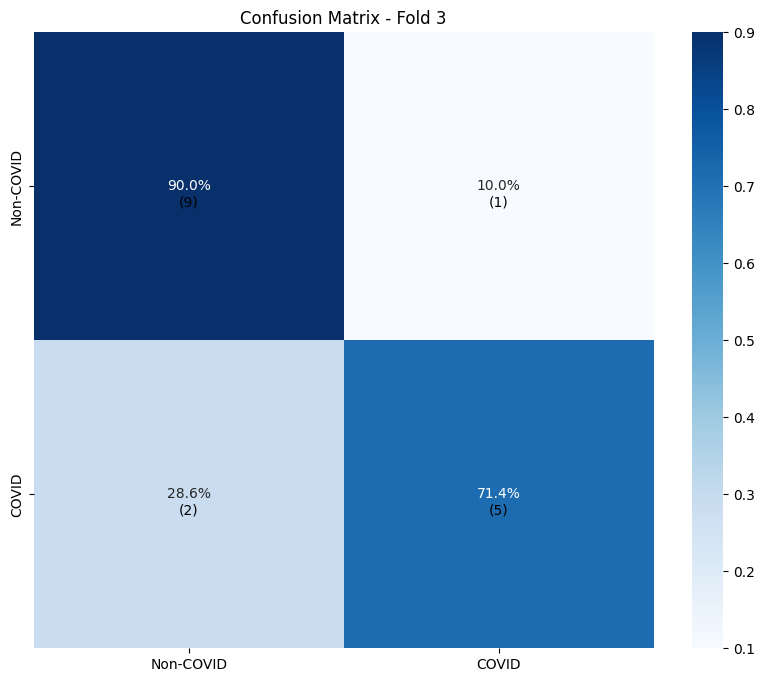

Fold 4, Epoch 0:
Training Accuracy: 58.12%
Validation Accuracy: 76.47%
Fold 4, Epoch 5:
Training Accuracy: 70.94%
Validation Accuracy: 76.47%
Fold 4, Epoch 10:
Training Accuracy: 83.76%
Validation Accuracy: 82.35%
Fold 4, Epoch 15:
Training Accuracy: 86.32%
Validation Accuracy: 94.12%
Fold 4, Epoch 20:
Training Accuracy: 89.74%
Validation Accuracy: 94.12%
Fold 4, Epoch 25:
Training Accuracy: 91.45%
Validation Accuracy: 82.35%
Fold 4, Epoch 30:
Training Accuracy: 94.02%
Validation Accuracy: 88.24%
Fold 4, Epoch 35:
Training Accuracy: 95.73%
Validation Accuracy: 82.35%
Fold 4, Epoch 40:
Training Accuracy: 93.16%
Validation Accuracy: 82.35%
Fold 4, Epoch 45:
Training Accuracy: 95.73%
Validation Accuracy: 94.12%
| Fold 4  |       97.44 % |       82.35 % |


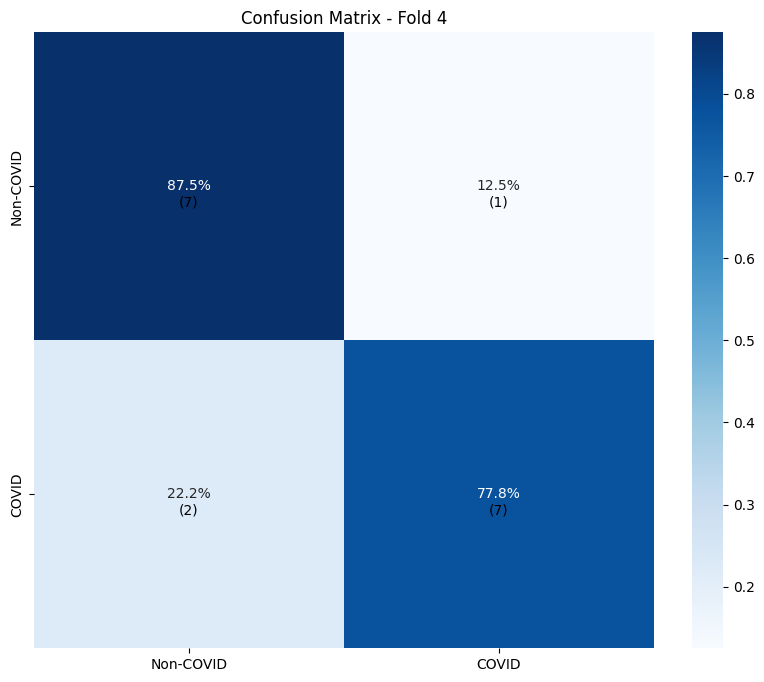

Fold 5, Epoch 0:
Training Accuracy: 57.26%
Validation Accuracy: 82.35%
Fold 5, Epoch 5:
Training Accuracy: 70.09%
Validation Accuracy: 82.35%
Fold 5, Epoch 10:
Training Accuracy: 74.36%
Validation Accuracy: 88.24%
Fold 5, Epoch 15:
Training Accuracy: 84.62%
Validation Accuracy: 82.35%
Fold 5, Epoch 20:
Training Accuracy: 90.60%
Validation Accuracy: 76.47%
Fold 5, Epoch 25:
Training Accuracy: 91.45%
Validation Accuracy: 76.47%
Fold 5, Epoch 30:
Training Accuracy: 92.31%
Validation Accuracy: 82.35%
Fold 5, Epoch 35:
Training Accuracy: 93.16%
Validation Accuracy: 76.47%
Fold 5, Epoch 40:
Training Accuracy: 95.73%
Validation Accuracy: 82.35%
Fold 5, Epoch 45:
Training Accuracy: 96.58%
Validation Accuracy: 76.47%
| Fold 5  |       95.73 % |       76.47 % |


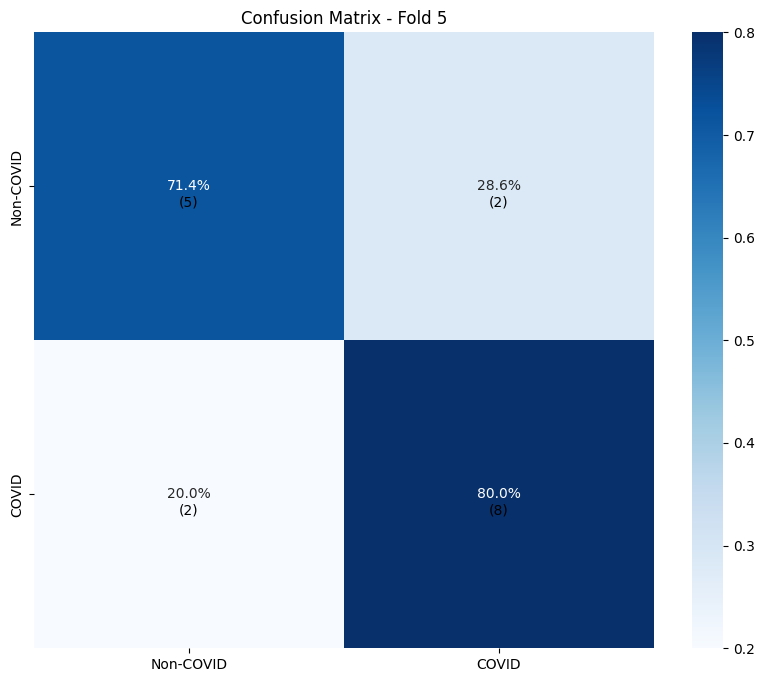

Fold 6, Epoch 0:
Training Accuracy: 54.24%
Validation Accuracy: 31.25%
Fold 6, Epoch 5:
Training Accuracy: 72.03%
Validation Accuracy: 81.25%
Fold 6, Epoch 10:
Training Accuracy: 79.66%
Validation Accuracy: 81.25%
Fold 6, Epoch 15:
Training Accuracy: 85.59%
Validation Accuracy: 93.75%
Fold 6, Epoch 20:
Training Accuracy: 89.83%
Validation Accuracy: 93.75%
Fold 6, Epoch 25:
Training Accuracy: 93.22%
Validation Accuracy: 93.75%
Fold 6, Epoch 30:
Training Accuracy: 95.76%
Validation Accuracy: 93.75%
Fold 6, Epoch 35:
Training Accuracy: 95.76%
Validation Accuracy: 93.75%
Fold 6, Epoch 40:
Training Accuracy: 97.46%
Validation Accuracy: 93.75%
Fold 6, Epoch 45:
Training Accuracy: 97.46%
Validation Accuracy: 93.75%
| Fold 6  |       97.46 % |       93.75 % |


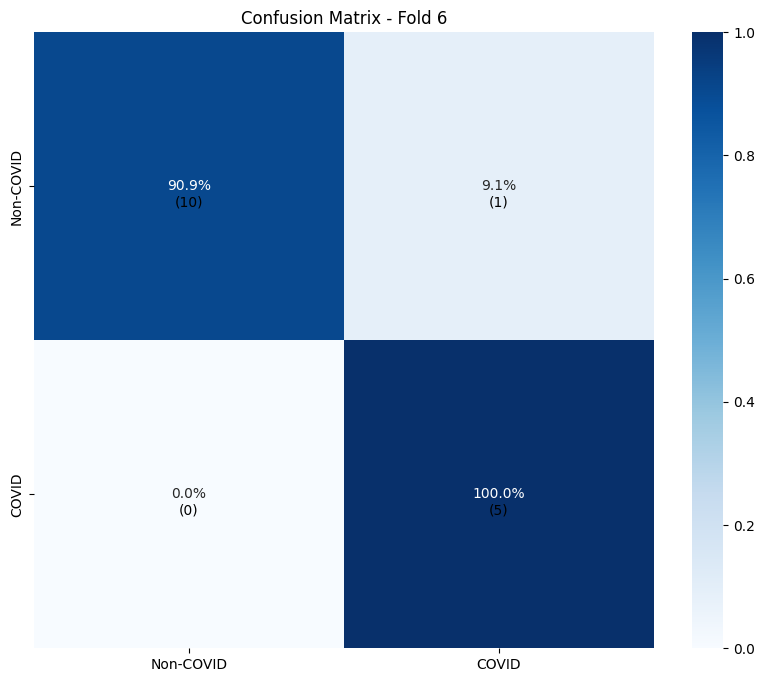

Fold 7, Epoch 0:
Training Accuracy: 62.71%
Validation Accuracy: 81.25%
Fold 7, Epoch 5:
Training Accuracy: 72.88%
Validation Accuracy: 81.25%
Fold 7, Epoch 10:
Training Accuracy: 81.36%
Validation Accuracy: 68.75%
Fold 7, Epoch 15:
Training Accuracy: 87.29%
Validation Accuracy: 56.25%
Fold 7, Epoch 20:
Training Accuracy: 92.37%
Validation Accuracy: 68.75%
Fold 7, Epoch 25:
Training Accuracy: 90.68%
Validation Accuracy: 62.50%
Fold 7, Epoch 30:
Training Accuracy: 90.68%
Validation Accuracy: 62.50%
Fold 7, Epoch 35:
Training Accuracy: 96.61%
Validation Accuracy: 62.50%
Fold 7, Epoch 40:
Training Accuracy: 94.07%
Validation Accuracy: 68.75%
Fold 7, Epoch 45:
Training Accuracy: 95.76%
Validation Accuracy: 62.50%
| Fold 7  |       96.61 % |       62.50 % |


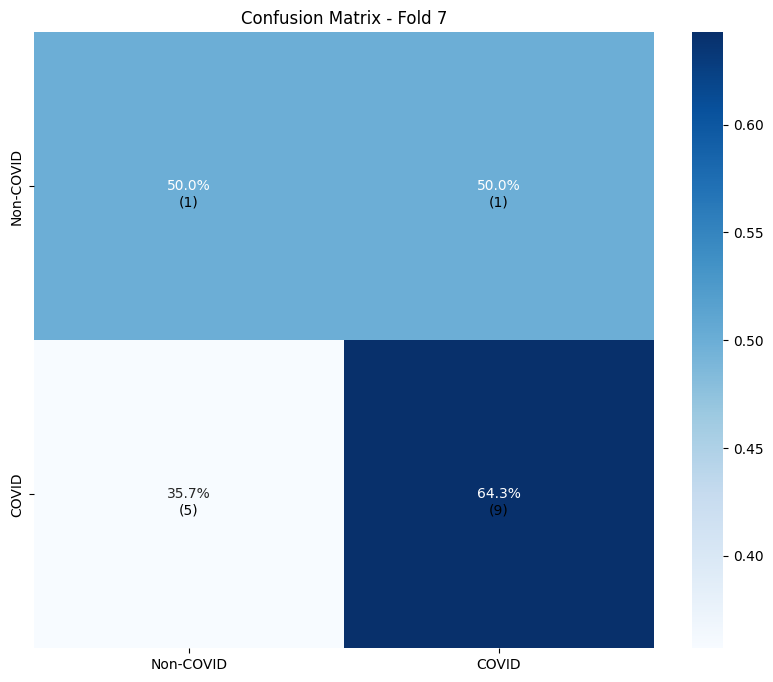

--------------------------------------------
| Average |       96.43 % |       85.39 % |


In [42]:
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------------------')
print('|         | Train Accuracy | Test Accuracy |')
print('--------------------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold.split(indices)):
    # Split all features according to fold indices
    scalar_features_train = scalar_features[train_ids]
    spectrograms_train = spectrograms[train_ids]
    chromagrams_train = chromagrams[train_ids]
    y_train = labels[train_ids]
    
    scalar_features_test = scalar_features[test_ids]
    spectrograms_test = spectrograms[test_ids]
    chromagrams_test = chromagrams[test_ids]
    y_test = labels[test_ids]
    
    # Scale scalar features
    scaler = StandardScaler()
    scalar_features_train = scaler.fit_transform(scalar_features_train)
    scalar_features_test = scaler.transform(scalar_features_test)
    
    # Create datasets
    train_dataset = CombinedDataset(
        scalar_features_train,
        spectrograms_train,
        chromagrams_train,
        y_train
    )
    
    test_dataset = CombinedDataset(
        scalar_features_test,
        spectrograms_test,
        chromagrams_test,
        y_test
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=hparams['batch_size'],
        shuffle=True
    )
    
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=hparams['batch_size'],
        shuffle=False
    )
    
    # Create model
    model = CoughNetWithCNN(len(scalar_features_train[0])).to(device)

    # Construct loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])
    criterion = torch.nn.CrossEntropyLoss()

    # Add monitoring for best model
    best_accuracy = 0.0
    best_model_state = None

    # Training loop
    for epoch in range(hparams['epochs']):
        train_accuracy = train(train_loader, model, optimizer, epoch)
        eval_accuracy, eval_predictions, eval_labels = evaluate(test_loader, model, epoch, return_predictions=True)
        
        # Print progress every 5 epochs
        if epoch % 5 == 0:
            print(f'Fold {fold}, Epoch {epoch}:')
            print(f'Training Accuracy: {train_accuracy*100:.2f}%')
            print(f'Validation Accuracy: {eval_accuracy*100:.2f}%')
            
        # Save best model
        if eval_accuracy > best_accuracy:
            best_accuracy = eval_accuracy
            best_model_state = copy.deepcopy(model.state_dict())
    
    # Save the best model for this fold
    torch.save({
        'fold': fold,
        'model_state': best_model_state,
        'scaler': scaler,
        'accuracy': best_accuracy,
        'hparams': hparams
    }, f'model_fold_{fold}.pth')
        
    results_train.append(train_accuracy)
    results_test.append(eval_accuracy)
    print(f'| Fold {fold}  |       {train_accuracy*100:.2f} % |       {eval_accuracy*100:.2f} % |')

    # Plot confusion matrix for this fold
    plot_confusion_matrix(eval_labels, eval_predictions, fold=fold)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.show()

print('--------------------------------------------')
print(f'| Average |       {np.mean(results_train)*100:.2f} % |       {np.mean(results_test)*100:.2f} % |')